# Imports and data load

In [1]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf  

from collections import Counter

In [ ]:
# Variables

LOAD_PREPROCESSED = False

In [2]:
#load data, working on a sample
df = pd.read_csv('../raw_data/train.csv')
df['discourse_type']=df['discourse_type'].replace('Concluding Statement','Concluding_Statement') ## for later
df.head(2)

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59


In [3]:
def is_not_sentence(text):
    if '.' not in text[-5:] or not text[0].isupper():
        return 0
    return 1

In [4]:
## let's check the proportion of sentences
df['is_not_sent']=df['discourse_text'].apply(is_not_sentence)
p = df['is_not_sent'].sum()/2/len(df)
print(f"There is approximatively {p*100:.2f}% of discourses not limited by a sentence")

There is approximatively 25.65% of discourses not limited by a sentence


# Preprocess the data

Objective = get the data at sentence level

In [77]:
#Pseudo code : 
# 1- create a match predictionstring-label-word
    # a) repeat label
    # b) groupby id / join 
    # c) match id/full text
    
# 2- go the other way around : from full text / ps / label to sentences / ps / label 
    # a) get the indice of the end of a sentence ; explode our dataset
    # b) split by this indice for ps and labels
    
# 3- choose a type for sentences with 2 types

In [78]:
def get_essay(id_,mode='train'):
    """Function to get the full text of an essay from the .txt file.

    Args:
        id_ (str): id of the essay
        mode (str, optional): determines whether to access *train* or *test* texts. \
        Defaults to 'train'.

    Returns:
        str: Returns the full text of the id
    """
    with open(os.path.join('../raw_data',mode,f'{id_}.txt'),'r') as file:
        txt = file.read()
    return txt.strip()

In [79]:
def repeater(label,txt):
    """
    Repeat discourse_type * length of discourse
    """
    words=[]
    labels=[]
    for w in txt.split():
        if '.' in w[-2:]:
            labels.append(label+'.')
        else:
            labels.append(label)
    return ' '.join(labels)

repeater_vect = np.vectorize(repeater) #vectorize our function

df['labels'] = repeater_vect(df['discourse_type'],df['discourse_text']) #apply

In [80]:
df.head(1)

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,is_not_sent,labels
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,1,Lead Lead Lead Lead Lead Lead Lead Lead. Lead ...


In [81]:
#recreate dataset at essay level 
df_essay=df.groupby('id').agg({'predictionstring':' '.join,'labels':' '.join}).reset_index()
df_essay.head(1)

,id,predictionstring,labels
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...


In [82]:
#retrieve full text
df_essay['text']=df_essay['id'].apply(get_essay) #get essay full text for each id
assert(df_essay.shape[0]==15594) #check
df_essay.head(3)

,id,predictionstring,labels,text
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o..."
1,00066EA9880D,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Lead Lead Lead Lead Lead Lead Lead Lead Lead L...,Driverless cars are exaclty what you would exp...
2,000E6DE9E817,2 3 4 5 6 7 8 10 11 12 13 14 15 16 17 18 19 20...,Position Position Position Position Position P...,Dear: Principal\n\nI am arguing against the po...


In [83]:
#Get the indices of the last word of a sentence, meaning position of all the words followed by a '.'
df_essay['idx_last_word']=df_essay['text'].apply(lambda text : [i for i, w in enumerate(text.split()) if '.' in w[-2:]])
df_essay.head(3)

,id,predictionstring,labels,text,idx_last_word
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...","[15, 20, 33, 50, 68, 83, 116, 133, 139, 153, 1..."
1,00066EA9880D,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Lead Lead Lead Lead Lead Lead Lead Lead Lead L...,Driverless cars are exaclty what you would exp...,"[10, 27, 47, 62, 76, 97, 123, 153, 169, 194, 2..."
2,000E6DE9E817,2 3 4 5 6 7 8 10 11 12 13 14 15 16 17 18 19 20...,Position Position Position Position Position P...,Dear: Principal\n\nI am arguing against the po...,"[53, 72, 80, 114, 136, 171, 212, 241, 265, 271..."


In [95]:
## 1- explode the dataset on column indices
df_essay = df_essay.explode('idx_last_word')

# /!\We have 11 strange essays wandering around without any punctuation : ciao /!\
print(df_essay.shape)
df_essay.dropna(axis=0,how='any',inplace=True)
print(df_essay.shape)

(313505, 5)
(313494, 5)


In [97]:
df_essay

,id,predictionstring,labels,text,idx_last_word
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",15
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",20
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",33
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",50
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",68
...,...,...,...,...,...
15593,FFFF80B8CC2F,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Evidence Evidence Evidence Evidence Evidence E...,Venus is a planet what belong the System Solar...,79
15593,FFFF80B8CC2F,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Evidence Evidence Evidence Evidence Evidence E...,Venus is a planet what belong the System Solar...,97
15593,FFFF80B8CC2F,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Evidence Evidence Evidence Evidence Evidence E...,Venus is a planet what belong the System Solar...,140
15593,FFFF80B8CC2F,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Evidence Evidence Evidence Evidence Evidence E...,Venus is a planet what belong the System Solar...,156


In [100]:
## 2- create 'artificially' an 'idx_first_word' column by shifting idx_last_word col
## /!\ We will not add nor subtract at this point to avoid confusion /!\



df_essay['idx_first_word'] = df_essay.groupby('id')['idx_last_word'].shift(1) ## We shift per essay !

df_essay['idx_first_word'].fillna(0,inplace=True) #replace NaN with 0 as it is the first word

In [101]:
## objective now = split ps, labels and text according to idx_first_word and idx_last_word 

def slicer(text,idx_first_word,idx_last_word):
    text = text.split()
    if idx_first_word==0:
        return ' '.join(text[:idx_last_word+1])
    return ' '.join(text[idx_first_word+1:idx_last_word+1])
    
slicer_vect=np.vectorize(slicer) #vectorize

In [109]:
## type issue 
df_essay['idx_last_word']=df_essay['idx_last_word'].astype(int)

In [112]:
#apply our magical slicer 

df_essay['sentence']=slicer_vect(df_essay['text'],df_essay['idx_first_word'],df_essay['idx_last_word'])
df_essay['ps']=slicer_vect(df_essay['predictionstring'],df_essay['idx_first_word'],df_essay['idx_last_word'])
df_essay['type']=slicer_vect(df_essay['labels'],df_essay['idx_first_word'],df_essay['idx_last_word'])

In [116]:
## Now we can have a clean dataset
df_essay.reset_index(inplace=True,drop=True)
df_preproc = df_essay.drop(['predictionstring','labels','text','idx_first_word','idx_last_word'],axis=1)
df_preproc.head()

,id,sentence,ps,type
0,0000D23A521A,"Some people belive that the so called ""face"" o...",0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15,Position Position Position Position Position P...
1,0000D23A521A,This is not the case.,16 17 18 19 20,Position Position Position Position Position.
2,0000D23A521A,The face on Mars is a naturally occuring land ...,21 22 23 24 25 26 27 28 29 30 31 32 33,Position Position Position Position Position P...
3,0000D23A521A,"It was not created by aliens, and there is no ...",34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 4...,Evidence Evidence Evidence Evidence Evidence E...
4,0000D23A521A,There is no evidence that NASA has found that ...,51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 6...,Evidence Evidence Evidence Evidence Evidence E...


## Let's attribute a single discourse type per sentence

We'll also check our initial assumption by looking at initial % of sentences of each type

In [118]:
df_preproc['type_len']=df_preproc['type'].apply(lambda txt:Counter(txt.replace('.','').split()))

In [272]:
## create a function
def length_checker(dict_):
    #if len(dict_.keys())==1:
     #   return 1
    try: #len(dict_.keys())==2:
        return max(dict_.values())/sum(dict_.values())
    except:
        return 'Coucou'
    else:
        return None

In [273]:
df_preproc['type_prop']=df_preproc['type_len'].apply(length_checker)
df_preproc.head()

,id,sentence,ps,type,type_len,type_prop,label
0,0000D23A521A,"Some people belive that the so called ""face"" o...",0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15,Position Position Position Position Position P...,{'Position': 16},1.0,Position
1,0000D23A521A,This is not the case.,16 17 18 19 20,Position Position Position Position Position.,{'Position': 5},1.0,Position
2,0000D23A521A,The face on Mars is a naturally occuring land ...,21 22 23 24 25 26 27 28 29 30 31 32 33,Position Position Position Position Position P...,{'Position': 13},1.0,Position
3,0000D23A521A,"It was not created by aliens, and there is no ...",34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 4...,Evidence Evidence Evidence Evidence Evidence E...,{'Evidence': 17},1.0,Evidence
4,0000D23A521A,There is no evidence that NASA has found that ...,51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 6...,Evidence Evidence Evidence Evidence Evidence E...,{'Evidence': 18},1.0,Evidence


In [275]:
df_preproc[(df_preproc.type_prop == 'Coucou')].id

,id,sentence,ps,type,type_len,type_prop,label
41,00066EA9880D,Becuase of all of these problems that arise wi...,,,{},Coucou,None
51,000E6DE9E817,I am against this policy change.,,,{},Coucou,None
52,000E6DE9E817,"Sincerely, Student.",,,{},Coucou,None
243,0027FC00C35B,Now back to the questions.,,,{},Coucou,None
244,0027FC00C35B,Are you willing to get on this phone while dri...,,,{},Coucou,None
...,...,...,...,...,...,...,...
313398,FFE4B98E0B1E,By designing their own projects students can g...,,,{},Coucou,None
313434,FFF1442D6698,Students don't like doing work during the summ...,,,{},Coucou,None
313470,FFF868E06176,The summer break projects created by the stude...,,,{},Coucou,None
313482,FFFD0AF13501,You can go so many places and you rarely go to...,,,{},Coucou,None


There is 17.64% of sentences composed with two discourse type. No sentence with more than 2 discourse types as 
type_prop >0.5


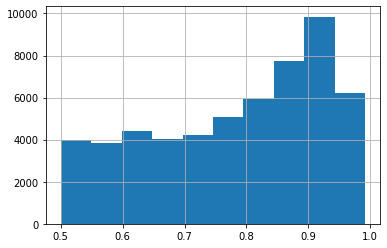

In [132]:
#First, our initial number was more or less correct:
print(f"There is {len(df_preproc[df_preproc['type_prop']<1])/len(df_preproc)*100:.2f}% of sentences composed with two discourse type. No sentence with more than 2 discourse types as \ntype_prop >0.5") 
df_preproc[df_preproc['type_prop']<1]['type_prop'].hist(bins=10);

## FAUX

In [133]:
# default needed to avoid throwing error
df_preproc['label']=df_preproc['type_len'].apply(lambda dict_ : max(dict_,key=dict_.get,default=None))

In [144]:
df_preproc.label.value_counts()/len(df_preproc)

Evidence                0.536202
Concluding_Statement    0.134127
Claim                   0.130290
Lead                    0.079529
Position                0.043053
Counterclaim            0.019343
Rebuttal                0.017059
Name: label, dtype: float64

In [145]:
df.discourse_type.value_counts()/len(df)

Claim                   0.347959
Evidence                0.316731
Position                0.106859
Concluding_Statement    0.093594
Lead                    0.064487
Counterclaim            0.040314
Rebuttal                0.030057
Name: discourse_type, dtype: float64

In [ ]:
### ISSUE ? 

### Let's try to tackle our big imbalance issue ?

<strong><font size=3 color='red'>TODO wtf 5% de None ??????</font></strong>

In [211]:
## toudoulou
df_shuffled['label'].value_counts().sum()/len(df_shuffled)

0.9596036925746585

#### Basic approach

In [204]:
## Let's create a perfectly balanced dataset with n samples of the less represented discourse
n = min(df_shuffled['label'].value_counts())

df_balanced = pd.DataFrame(columns = df_shuffled.columns)

labels = ['Evidence', 'Lead', 'Claim', 'Concluding_Statement','Rebuttal', 'Counterclaim', 'Position']


for label in labels:
    df_ = df_shuffled[df_shuffled['label']==label].sample(n)
    df_balanced = df_balanced.append(df_)

In [209]:
#WOUP # WOUP its never gonna woooorrrrkkkkk
len(df_balanced)/len(df_shuffled)

0.11941536361142478

In [258]:
## NB 
df_balanced.head(1)

,id,sentence,ps,type,type_len,type_prop,label,len_sen
134624,3FB5387479C5,"For example, some parents have to work double ...",144 145 146 147 148 149 150 151 152 153 154 15...,Evidence Evidence Evidence Evidence Evidence E...,"{'Evidence': 26, 'Claim': 11}",0.702703,Evidence,183
277578,8197AEA0CC61,On we go with this debate but now on the cons ...,172 173 174 175 176 177 178 179 180 181 182 18...,Evidence Evidence Evidence Evidence Evidence E...,{'Evidence': 15},1.000000,Evidence,70
38151,0B994B3916FB,Distance learning is an education gained throu...,628 629 630 631 632 633 634 635 636 637 638 63...,Evidence Evidence Evidence Evidence Evidence E...,{'Evidence': 17},1.000000,Evidence,108
174392,F7149C7BC3B3,Another reason is because of the angle that we...,111 112 113 114 115 116 117 118 119 120 121 12...,Evidence Evidence Evidence Evidence Evidence E...,{'Evidence': 13},1.000000,Evidence,65
59506,415367DCB6DE,Being a Seagoing Coyboy let's you have the tim...,63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78,Claim Claim Claim Claim. Evidence Evidence Evi...,"{'Claim': 4, 'Evidence': 12}",0.750000,Evidence,86


#### Doigt mouillé approach

In [251]:
## another approach : still imbalance but less balanced -__-

n = min(df_shuffled['label'].value_counts())
display(df_shuffled['label'].value_counts()/n)

# idea would be to diminish the ratio ; doigt mouillé bonjour ; we'll obviously keep 'Rebuttal to 1'
random_guess_ratio = df_shuffled['label'].value_counts()/n/[5,2,2,2,1,1,1]
random_guess_ratio

Evidence                31.431563
Concluding_Statement     7.862378
Claim                    7.637435
Lead                     4.661930
Position                 2.523747
Counterclaim             1.133882
Rebuttal                 1.000000
Name: label, dtype: float64

Evidence                6.286313
Concluding_Statement    3.931189
Claim                   3.818717
Lead                    2.330965
Position                2.523747
Counterclaim            1.133882
Rebuttal                1.000000
Name: label, dtype: float64

In [252]:
df_balanced_yolo = pd.DataFrame(columns = df_shuffled.columns)

labels = ['Evidence', 'Concluding_Statement', 'Claim','Lead', 'Position', 'Counterclaim', 'Rebuttal']

for label,weight in zip(labels,random_guess_ratio):
    df_ = df_shuffled[df_shuffled['label']==label].sample(int(n*weight))
    df_balanced_yolo = df_balanced_yolo.append(df_)

In [254]:
df_balanced_yolo['label'].value_counts()/df_balanced_yolo['label'].value_counts().sum()

Evidence                0.298998
Concluding_Statement    0.186981
Claim                   0.181627
Position                0.120030
Lead                    0.110869
Counterclaim            0.053931
Rebuttal                0.047564
Name: label, dtype: float64

In [265]:
df_balanced_yolo.loc[145468]

id                                                60C7488B4167
sentence     Most of the stuuf you do on the job is that yo...
ps           113 114 115 116 117 118 119 120 121 122 123 12...
type         Evidence Evidence Evidence Evidence Evidence E...
type_len     {'Evidence': 13, 'Claim': 5, 'Concluding_State...
type_prop                                                  NaN
label                                                 Evidence
len_sen                                                    105
Name: 145468, dtype: object

#### FYI useless approach

In [232]:
### OR NEW APPROACH ! 
## We will replicate the distribution that we have in the original train.csv file, using number of words

df['discourse_len'] = df['predictionstring'].apply(lambda txt : len(txt.split()))
types_prop_df=df.groupby('discourse_type')[['discourse_len']].sum().reset_index()
types_prop_df['distribution']=types_prop_df['discourse_len']/types_prop_df['discourse_len'].sum()

## OK spoiler alert it does not change a thing :) 

# Modeling 

## Split the data

In [146]:
## We can not do a sample train test split : we would loose the connexion to our id ! Let's shuffle our df and create index

VAL_SPLIT = .8
TEST_SPLIT = .9

df_shuffled = df_preproc.sample(frac=1).reset_index(drop=True) #shuffle without replacement keeping all rows

LEN=len(df_shuffled)

idx_val=int(LEN*VAL_SPLIT)
idx_test=int(LEN*TEST_SPLIT)

idx_train=list(range(0,idx_val))
idx_val=list(range(idx_val,idx_test))
idx_test=list(range(idx_test,LEN))

assert(len(idx_test)+len(idx_train)+len(idx_val)==LEN)

In [147]:
## Create our train, val, test split

x_train = df_shuffled.loc[idx_train,'sentence'].values ## needs the .values to have an array, needed for the model
x_val = df_shuffled.loc[idx_val,'sentence'].values ## needs the .values to have an array, needed for the model
x_test = df_shuffled.loc[idx_test,'sentence'].values ## needs the .values to have an array, needed for the model

y_train = df_shuffled.loc[idx_train,'label'].values ## needs the .values to have an array, needed for the model
y_val = df_shuffled.loc[idx_val,'label'].values ## needs the .values to have an array, needed for the model
y_test = df_shuffled.loc[idx_test,'label'].values ## needs the .values to have an array, needed for the model



In [148]:
## Create OHE for y

#label mapping
list_labels = pd.Series(y_train.flatten()).unique() #Serie + simple
label_map = {l:i for i,l in enumerate(list_labels)}
label_map

y_train_mapped = np.vectorize(label_map.get)(y_train)
y_val_mapped = np.vectorize(label_map.get)(y_val)
y_test_mapped = np.vectorize(label_map.get)(y_test)


y_train_ohe = np.zeros((len(y_train),len(label_map)))
y_val_ohe = np.zeros((len(y_val),len(label_map)))
y_test_ohe = np.zeros((len(y_train),len(label_map)))

y_train_ohe[np.arange(len(y_train)),y_train_mapped]=1
y_val_ohe[np.arange(len(y_val)),y_val_mapped]=1
y_test_ohe[np.arange(len(y_test)),y_test_mapped]=1


## Let's take the opportunity to get an idea of a simple baseline

In [176]:
#tokenize

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_tok = tokenizer.texts_to_sequences(x_train)
x_val_tok = tokenizer.texts_to_sequences(x_val)
x_test_tok = tokenizer.texts_to_sequences(x_test)


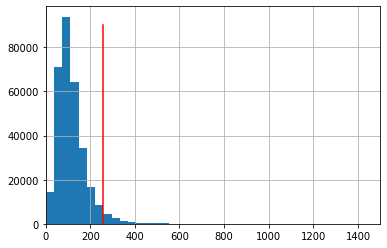

In [168]:
#check distribution of length of distribution to determine padding 

df_shuffled['len_sen']=df_shuffled['sentence'].apply(len)
df_shuffled['len_sen'].hist(bins=100)
plt.xlim(0,1500)
plt.plot([256,256],[0,90000],c='r')

In [164]:
(1-len(df_shuffled[df_shuffled.len_sen>256])/len(df_shuffled)).__format__('.2f')+'% sentences captured'

'0.97% sentences captured'

In [169]:
#padding

x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_tok, 
                                                            dtype='float32', padding='post',maxlen=256)
x_val_pad = tf.keras.preprocessing.sequence.pad_sequences(x_val_tok, 
                                                          dtype='float32', padding='post',maxlen=256)
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_tok, 
                                                           dtype='float32', padding='post',maxlen=256)

## Using simple embeddings and LSTM layers

In [170]:
## Define variables for our embedding layer
vocab_size = len(tokenizer.word_index)
vocab_size

47842

### Model architectures

In [177]:
## Create simplest model e v e r 

def simple_model():
    
    x = tf.keras.layers.Embedding(input_dim=vocab_size + 1, output_dim=64, mask_zero=True)(inputs)
    
    x = tf.keras.layers.LSTM(units = 256, activation = 'tanh', return_sequence=True)(x)
    x = tf.keras.layers.LSTM(units = 128, activation = 'tanh')(x)
    
    x = tf.keras.layers.Dense(58,activation='relu')(x)
    
    outputs = tf.keras.layers.Dense(8,activation='softmax')(x)

    return model 

In [210]:
def simple_model_bidirectionnal():
    
    x = tf.keras.layers.Embedding(input_dim=vocab_size + 1, output_dim=64, mask_zero=True)(inputs)
    
    x = tf.keras.layers.Bidirectional(LSTM(units = 256, activation = 'tanh', return_sequence=True))(x)
    x = tf.keras.layers.Bidirectional(LSTM(units = 128, activation = 'tanh'))(x)
    
    x = tf.keras.layers.Dense(58,activation='relu')(x)
    
    outputs = tf.keras.layers.Dense(8,activation='softmax')(x)

    return model 

### Model compilation and callbacks 

In [255]:
#init objects

loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy()
lr_scheduler 
optimizer = tf.keras.optimizers.Adam()

2022-02-18 21:31:25.802181: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [257]:
# callbacks 

#paths
checkpoints_path_simple = '/content/drive/MyDrive/feedback-prize/checkpoints/sentences_simple.ckpt'
checkpoints_path_bi = '/content/drive/MyDrive/feedback-prize/checkpoints/sentences_bi.ckpt'
logdir = '/content/drive/MyDrive/feedback-drive/logs/'

es = tf.keras.callbacks.EarlyStopping(patience=1)

checkpoint_saver_simple = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoints_path_simple,
                                                      save_weights_only=True,
                                                      save_best_only = True,
                                                      monitor = 'val_categorical_accuracy',
                                                      mode = 'max',
                                                      verbose = 1)

checkpoint_saver_simple = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoints_path_bi,
                                                      save_weights_only=True,
                                                      save_best_only = True,
                                                      monitor = 'val_categorical_accuracy',
                                                      mode = 'max',
                                                      verbose = 1)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Transformers as embedder

In [ ]:
from transformers import TFBertModel,AutoTokenizer
pretrained_bert = TFBertModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
x_train_tok=tokenizer(list(x_train),truncation=True,max_length=DISCOURSE_LEN,padding='max_length',
              return_token_type_ids=False,return_tensors='np')